## SETUP

In [93]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

## PARAMETERS

In [94]:
image_size = 512
generator_input = int(image_size/8)
batch_size = 4

## IMPORT

In [95]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "images_tf/American/", label_mode=None, image_size=(image_size, image_size), batch_size=batch_size, crop_to_aspect_ratio=True
)
dataset = dataset.map(lambda x: x / 255.0)

Found 1128 files belonging to 1 classes.


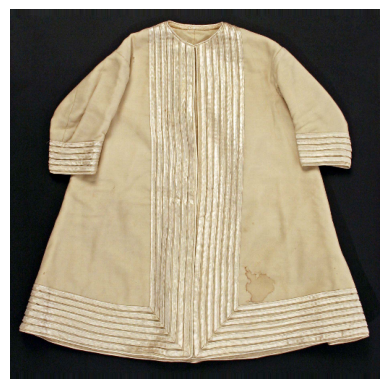

In [96]:
# display one image
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## DISCRIMINATOR

In [97]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 256, 256, 64)      3136      
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 256, 256, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 128, 128, 128)     131200    
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 128, 128, 128)     0         
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 128)       262272    
                                                                 
 leaky_re_lu_59 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 flatten_9 (Flatten)         (None, 524288)          

## GENERATOR

In [98]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(generator_input * generator_input * 128),
        layers.Reshape((generator_input, generator_input, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 524288)            67633152  
                                                                 
 reshape_10 (Reshape)        (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_30 (Conv2D  (None, 128, 128, 128)    262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 128, 128, 128)     0         
                                                                 
 conv2d_transpose_31 (Conv2D  (None, 256, 256, 256)    524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 256, 256, 256)     0 

## GAN

In [99]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## GAN monitor

In [100]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("BasicGAN_gen/4/generated_img_%03d_%d.png" % (epoch, i))

## FIT

In [101]:
learning_rate = 0.0001

In [102]:
epochs = 20  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/20
282/282 [==============================] - 205s 723ms/step - d_loss: 0.6006 - g_loss: 1.3338
Epoch 2/20
282/282 [==============================] - 197s 696ms/step - d_loss: 0.5888 - g_loss: 1.3188
Epoch 3/20
282/282 [==============================] - 197s 698ms/step - d_loss: 0.6005 - g_loss: 1.6996
Epoch 4/20
282/282 [==============================] - 214s 755ms/step - d_loss: 0.6205 - g_loss: 1.3952
Epoch 5/20
282/282 [==============================] - 214s 758ms/step - d_loss: 0.5702 - g_loss: 1.4005
Epoch 6/20
282/282 [==============================] - 214s 756ms/step - d_loss: 0.5343 - g_loss: 1.7503
Epoch 7/20
282/282 [==============================] - 210s 741ms/step - d_loss: 0.5907 - g_loss: 1.6588
Epoch 8/20
282/282 [==============================] - 200s 707ms/step - d_loss: 0.5503 - g_loss: 1.4720
Epoch 9/20
282/282 [==============================] - 199s 704ms/step - d_loss: 0.5511 - g_loss: 1.5704
Epoch 10/20
282/282 [==============================] - 201s 709m